In [2]:
import pystan, os, pygtc, pickle
import numpy as np, arviz as az, matplotlib.pyplot as plt
import os, numpy as np, matplotlib.pyplot as plt
from astropy.table import Table
import pickle
os.environ['STAN_NUM_THREADS'] = "1"  ## each chain uses 1 thread

### disk contamination model

$$ \large
\mathcal{L}_i = \frac{1}{\sqrt{2 \pi (\sigma_i^2 + \sigma_{\mathrm{int}}^2})} 
    \exp\left[ -\frac{(C_i - \widehat{C}_i)^2}
    {2 (\sigma_i^2 + \sigma_{\mathrm{int}}^2)} \right]
$$
where
$$ \large
	\widehat{C}_i = \frac{D}{|\sin{b_i}|} + C^{\mathrm{halo}}.
$$

Data set: $\large b_i, C_i$ 

Parameters: $\large D, C^{\mathrm{halo}}, \sigma_{\mathrm{int}}$


In [2]:
model = """
data {
  int <lower=0> J;               // number of tiles 
  real b[J];                     // galactic latitude of each tile
  real c[J];                     // u-g color of MSTOs in each tile
  real <lower=0> sigma[J];       // measurement uncertainties
}

parameters {
  real <lower=0> D;              // contamination factor
  real <lower=0> sigma_int;      // intrinsic scatter
  real c_halo;                   // true halo u-g color
}

transformed parameters {
  vector[J] c_hat;               // model observed u-g color
  vector[J] eff_sigma;           // effective scatter combining measurement and intrinsic
  for ( j in 1:J ) { 
      c_hat[j] = D / abs(sin(b[j])) + c_halo;
      eff_sigma[j] = sqrt(square(sigma[j]) + square(sigma_int));
  }
}

model {
  target += normal_lpdf(c | c_hat, eff_sigma ); // log-likelihood
} """

### reading data

In [3]:
data = Table.read("res_ug.fits", format='fits')
fields_inside = [137, 160, 235, 374, 34, 236, 59, 98, 327, 174, 274]

data['inside'] = False
for i, field in enumerate(data['field']):
    if field in fields_inside:
        data['inside'][i] = True

inside = data['inside']
outside = ~data['inside']

b = np.array(data['b'])
c = np.array(data['SDSS_mode_x0'])
sigma = np.array((data['SDSS_mode_x0_up'] - data['SDSS_mode_x0_lo']) / 2 )
J = len(b)

data_set = {'J':J, 'b':np.radians(b), 'c':c, 'sigma':sigma}

extra_compile_args = ['-pthread', '-DSTAN_THREADS']

### compile the stan C++ program

In [4]:
if 0: ## compile the model; need only to compile once
    
    sm = pystan.StanModel(model_code=model, extra_compile_args=extra_compile_args)
    
    with open('disk_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

else:
    
    sm = pickle.load(open('disk_model.pkl', 'rb'))

### run the sampler

In [8]:
# each dictionary for a chain
# guess = [{'D':0.5, 'C':0.5, 'simga_int':0.01}, {'D':0.6, 'C':0.6, 'simga_int':0.02}, 
#         {'D':0.7, 'C':0.7, 'simga_int':0.03}, {'D':0.8, 'C':0.8, 'simga_int':0.04}]


if 0:
    
    guess = 'random'

    fit = sm.sampling(data=data_set, init=guess, iter=2000, chains=6, n_jobs=6)
    
    print(fit.stansummary(pars=['D', 'sigma_int', 'c_halo'], digits_summary=4))
    
    az.plot_trace(fit, var_names=['D', 'sigma_int', 'c_halo'], chain_prop='color', compact=':')
    
    D = fit.extract()['D']
    C = fit.extract()['c_halo']
    int_sct = fit.extract()['sigma_int']

    chains = np.transpose(np.array([D, C, int_sct]))

    np.savetxt('chains_joint.dat', chains)

else:
    
    chains = np.loadtxt('chains_joint.dat')

### better triangle plot using pygtc

In [3]:
chains_north = np.loadtxt('chains_sep_north.dat')
chains_south = np.loadtxt('chains_sep_south.dat') 
chains_joint = np.loadtxt('chains_joint.dat')

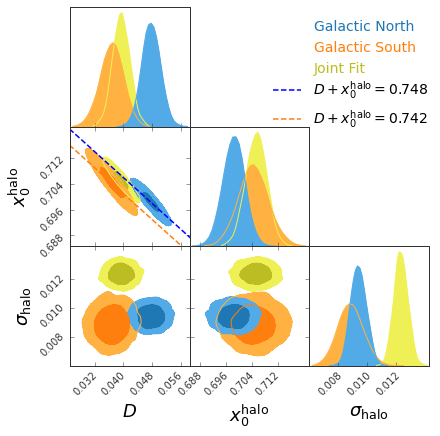

In [4]:
c_labels = ['Galactic North', 'Galactic South', 'Joint Fit']
mylabelfont = {'size':18}
mytickfont = {'size':10}
mylegendfont = {'size':14}
myparams = [r'$D$', r'$x_0^{\mathrm{halo}}$', r'$\sigma_\mathrm{halo}$']
mycolor = ['blues', 'oranges','yellows'] # ['greens', 'reds',  'browns', 'pinks', 'grays', 'yellows', 'cyans']
sdss_ranges = [(0.05, 0.11), (0.74, 0.82), (0.005,0.018)]
fig = pygtc.plotGTC(chains=[chains_north, chains_south, chains_joint], chainLabels=c_labels, paramNames=myparams,\
                    customTickFont=mytickfont, customLabelFont=mylabelfont, customLegendFont=mylegendfont, colorsOrder=mycolor, figureSize=6)


ax_list = fig.axes
ax = ax_list[0]

D_grid = np.linspace(0.02, 0.06, 100)
x0_grid = 0.746 - D_grid   ### 0.748 in the rounded D and C in Table 4; It really is 0.746
ax.plot(D_grid, x0_grid, 'b--', label=r'$D + x_0^{\mathrm{halo}} = 0.748$')

x0_grid = 0.741 - D_grid   ### 0.742 in the rounded D and C in Table 4; It really is 0.741
ax.plot(D_grid, x0_grid, 'C1--', label=r'$D + x_0^{\mathrm{halo}} = 0.742$')
ax.legend(frameon=False, prop={'size':14}, bbox_to_anchor=(3.1, 1.5))

plt.subplots_adjust(top=0.98, right=0.98, bottom=0.15, left=0.15)

### plot errorband

In [5]:
def disk_model(x, D, C):
    y = D/np.abs(np.sin(np.radians(x))) + C
    return y

def plot_errorbands(x, chains, ax, color, *args, **kwargs):

    D = chains[:,0]
    C = chains[:,1]
    int_scat = chains[:,2]

    #print(np.median(D), np.median(C), np.median(int_scat))

    N_data = len(x)                            ## number of data points
    N_iter = len(D)                            ## number of iteration; each iteration gives a model curve
    y_sct = np.zeros((N_iter, N_data))         ## each model curve predicts a set of y on x
  
    for i in range(N_iter):                    ## y_sct is model plus intrinsic scatter
        y_sct[i,:] =  disk_model(x, D[i], C[i]) +  np.random.normal(0, int_scat[i], N_data) 

    y50 = np.median(y_sct, axis=0)             ## median = best fit
    
    y84 = np.percentile(y_sct, 84, axis=0)     ## 1 sigma upper
    y16 = np.percentile(y_sct, 16, axis=0)     ## 1 sigma lower

    y975 = np.percentile(y_sct, 97.5, axis=0)  ## 2 sigma upper
    y25 = np.percentile(y_sct, 2.5, axis=0)    ## 2 sigma lower

    line, = ax.plot(x, y50, color, *args, **kwargs)
    ax.fill_between(x, y84, y16, alpha=0.25, color=line.get_color())
    ax.fill_between(x, y975, y25, alpha=0.25, color=line.get_color())

def plot_median(x, chains, ax, color, *args, **kwargs):

    D = chains[:,0]
    C = chains[:,1]
    int_scat = chains[:,2]

    N_data = len(x)                            ## number of data points
    N_iter = len(D)                            ## number of iteration; each iteration gives a model curve
    y_sct = np.zeros((N_iter, N_data))         ## each model curve predicts a set of y on x
  
    for i in range(N_iter):                    ## y_sct is model plus intrinsic scatter
        y_sct[i,:] =  disk_model(x, D[i], C[i]) +  np.random.normal(0, int_scat[i], N_data) 

    y50 = np.median(y_sct, axis=0)             ## median = best fit

    line, = ax.plot(x, y50, color, *args, **kwargs)


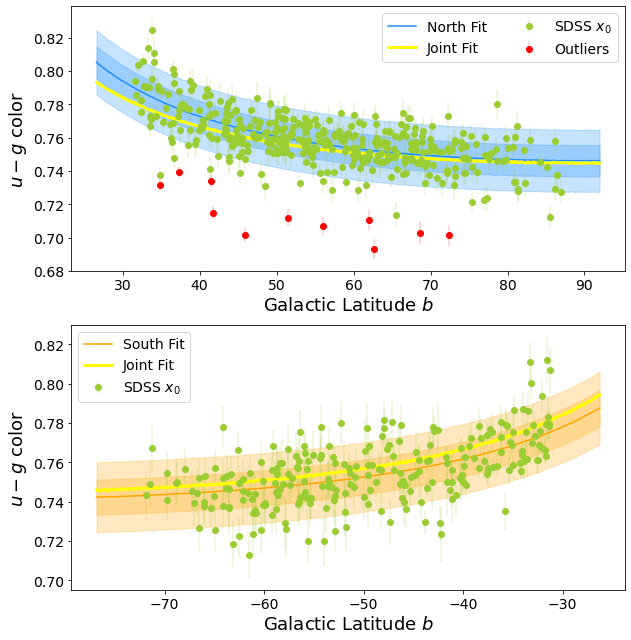

In [6]:
data = Table.read("res_ug.fits", format='fits')
fields_inside = [137, 160, 235, 374, 34, 236, 59, 98, 327, 174, 274]

data['inside'] = False
for i, field in enumerate(data['field']):
    if field in fields_inside:
        data['inside'][i] = True

b = np.array(data['b'])
c = np.array(data['SDSS_mode_x0'])
sigma = np.array((data['SDSS_mode_x0_up'] - data['SDSS_mode_x0_lo']) / 2 )

chains_north = np.loadtxt('chains_sep_north.dat')
chains_south = np.loadtxt('chains_sep_south.dat') 
chains_joint = np.loadtxt('chains_joint.dat') 

##############################################################################

fig = plt.figure(figsize=(9,9))
ax1 = plt.subplot(211)
ax1.set_xlabel(r'Galactic Latitude $b$', fontsize=18)
ax1.set_ylabel(r'$u-g$ color', fontsize=18)
ax2 = plt.subplot(212)
ax2.set_xlabel(r'Galactic Latitude $b$', fontsize=18)
ax2.set_ylabel(r'$u-g$ color', fontsize=18)

############### North ###############
ind, = np.where( (b>30) & ~data['inside'] ) # North non-cluster data
xgrid_north = np.linspace(b[ind].min()-5, b[ind].max()+5, 500)

ax1.errorbar(b[ind], c[ind], yerr=sigma[ind], fmt="o", c='yellowgreen', linewidth=0.3, label=r'SDSS $x_0$')
ax1.errorbar(b[data['inside']], c[data['inside']], yerr=sigma[data['inside']], fmt="o", c='red', linewidth=0.3, label='Outliers')
plot_errorbands(xgrid_north, chains_north, ax1, 'dodgerblue', label='North Fit')
plot_median(xgrid_north, chains_joint, ax1, 'yellow', linewidth=3, label='Joint Fit')

############### South ###############
ind, = np.where( (b<-30) ) # South non-cluster data
xgrid_south = np.linspace(b[ind].min()-5, b[ind].max()+5, 500)

ax2.errorbar(b[ind], c[ind], yerr=sigma[ind], fmt="o", c='yellowgreen', linewidth=0.3, label=r'SDSS $x_0$')
plot_errorbands(xgrid_south, chains_south, ax2, 'orange', label='South Fit')
plot_median(xgrid_south, chains_joint, ax2, 'yellow', linewidth=3, label='Joint Fit')

ax1.legend(prop={'size': 14}, ncol=2)
ax2.legend(prop={'size': 14}, loc='upper left')

ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.tight_layout()
